In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numba import njit

from scipy.stats import multivariate_normal
from scipy.special import rel_entr

def load_matplotlib_local_fonts():
    from matplotlib import font_manager
    
    font_path = '/home/barzon/Avenir.ttc'
    
    font_manager.fontManager.addfont(font_path)
    prop = font_manager.FontProperties(fname=font_path)

    #  Set it as default matplotlib font
    plt.rcParams.update({
        'font.sans-serif': prop.get_name(),
    })
    
load_matplotlib_local_fonts()

colors = plt.get_cmap('tab10')

/home/barzon/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:
@njit
def numba_random_normal(size):
    res = np.zeros(size)
    
    for idx in range(size):
        res[idx] = np.random.normal()
    
    return res

@njit
def step_linear(x, A, r, tau, h, dt):
    '''
    Function to perform a linear step in a simulation.

    Parameters:
    x : array-like
        Current state.
    A : array-like
        Matrix A used in the computation.
    r : array-like
        Vector of constants representing self-decay.
    h : array-like
        Vector representing external input.
    dt : float
        Time step.

    Returns:
    Updated state after applying the linear step.
    '''

    return x +  (-r * x + A @ x + h) * dt / tau + numba_random_normal(x.size) * np.sqrt(dt) / tau

@njit
def simulate(steps, A, r, tau, h, dt):
    states = np.zeros((steps, A.shape[0]))
    
    for t in range(1,steps):
        states[t] = step_linear(states[t-1], A, r, tau, h[t], dt)
        
    return states

@njit
def simulate_master_equation(steps, W, dt, p0):
    states = np.zeros((steps, W.shape[0]))
    states[0] = p0
    
    for t in range(1,steps):
        states[t] = states[t-1] + dt * W @ states[t-1]
        
    return states

@njit
def simulate_rates(steps, W, dt, h0):
    states = np.zeros(steps, dtype=np.int64)
    states[0] = h0
    
    for t in range(1,steps):
        ### Write rate equation
        probs = W[:,states[t-1]]*dt
        probs[states[t-1]] = 0
        probs[states[t-1]] = 1 - probs.sum()
        
        states[t] = np.where( np.random.random() < np.cumsum(probs) )[0][0]
        
    return states

# Examples for EI system

In [3]:
### Define constants of the system
N = 2
w = 1
k = 1.1

r = np.ones(2)

A = w * np.array([[1, -k], [1, -k]])

In [4]:
### Define constants of the simulation
steps = int(5e4)
dt = 0.005
tau = 1

h = np.zeros((steps,2))
h[:,0] = 10

In [5]:
### Compute expected average
beta = 1 + w*(k-1)

xplus = (h[0,0] + w*k*(h[0,0]-h[0,1])) / beta
xminus = (h[0,1] + w*(h[0,0]-h[0,1])) / beta
mus = np.array( [xplus, xminus] )

### Compute expected covariance
tt = 2*(1-w-w*k)*(2-w+k*w)
sigma = np.array([[2-w+3*k*w+2*k**2*w**2, w*(1-k+2*k*w)],[w*(1-k+2*k*w), 2-3*w+k*w+2*w**2]])
sigma = - sigma / tt

In [6]:
### Simulate
states = simulate(steps, A, r, tau, h, dt)

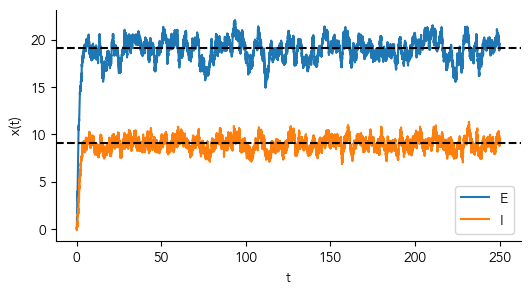

In [7]:
labels = ['E', 'I']

plt.figure(figsize=(6,3))

for idx, state in enumerate(states.T):
    plt.plot(np.arange(steps)*dt, state, c=colors(idx), label=labels[idx])
plt.axhline(xplus, c='k', ls='--')
plt.axhline(xminus, c='k', ls='--')

plt.xlabel('t')
plt.ylabel('x(t)')

plt.legend()

sns.despine()
plt.show()

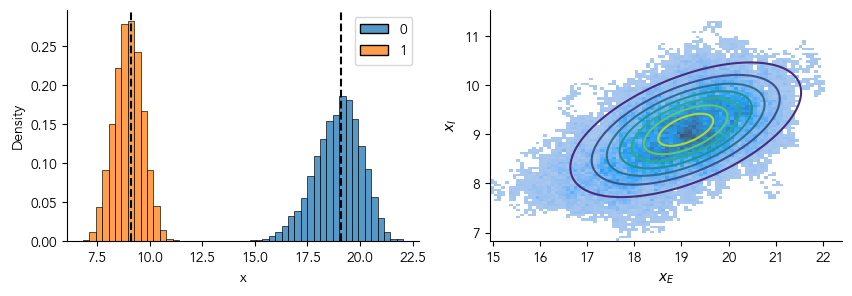

In [8]:
### Plot statistics at stationarity
t_min = int(1e3)

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
sns.histplot(states[t_min:], bins=50, stat='density')
plt.axvline(xplus, ls='--', c='k')
plt.axvline(xminus, ls='--', c='k')
sns.despine()
plt.xlabel('x')

plt.subplot(1,2,2)
ax = sns.histplot(x=states[t_min:,0], y=states[t_min:,1])

x, y = np.mgrid[states[t_min:,0].min():states[t_min:,0].max():.01, states[t_min:,1].min():states[t_min:,1].max():.01]
pos = np.dstack((x, y))
ax.contour(x,y, multivariate_normal(mean=mus, cov=sigma).pdf(pos))

plt.xlabel(r'$x_E$')
plt.ylabel(r'$x_I$')
sns.despine()

plt.show()

# Example of input dynamics

In [9]:
### Define constants of the inputs
M = 3
K = M - 1

tau_jumps = 1

wup_tilde = 0.05
wdown_tilde = 0.3

wup = tau_jumps * wup_tilde
wdown = tau_jumps * wdown_tilde

delta_h = 0.1
hs = np.arange(M) * delta_h

### Create transition matrix
W = np.zeros((M,M))
W[:,0] = wup
np.fill_diagonal(W, -wdown)
W[0] = np.array( [-K*wup] + [wdown]*K )
print(W)

### Compute expected stationary probabilities
p_stat = np.array( [wdown] + [wup]*K )
p_stat = p_stat / p_stat.sum()
print(p_stat)

[[-0.1   0.3   0.3 ]
 [ 0.05 -0.3   0.  ]
 [ 0.05  0.   -0.3 ]]
[0.75  0.125 0.125]


In [10]:
steps = int(1e6)
dt = 0.01
h0 = 0

inputs = simulate_rates(steps, W, dt, h0)

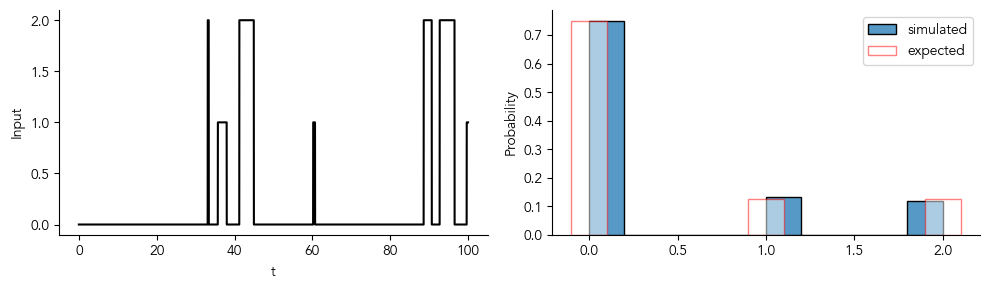

In [11]:
plt.figure(figsize=(10,3))

step_show = int(1e4)

plt.subplot(1,2,1)
plt.plot(np.arange(step_show)*dt, inputs[:step_show], c='k')
plt.xlabel('t')
plt.ylabel('Input')

plt.subplot(1,2,2)
sns.histplot(inputs, stat='probability', bins=10, label='simulated')
plt.bar(np.arange(M), p_stat, color='white', edgecolor='r', alpha=0.5, width=0.2, label='expected')
sns.despine()
plt.legend()

plt.tight_layout()
plt.show()

# Combined system - two states

In [12]:
def create_info_system(N, w, k, tau_ei, r):
    A = w * np.array([[1, -k], [1, -k]])
    return {'N': N, 'w': w, 'k': k, 'tau_ei': tau_ei, 'r': r, 'A': A}

def create_info_input(M, wup, wdown, hs):
    ### Create transition matrix
    K = M-1
    W = np.zeros((M,M))
    W[:,0] = wup
    np.fill_diagonal(W, -wdown)
    W[0] = np.array( [-K*wup] + [wdown]*K )
    
    return {'M': M, 'wup': wup, 'wdown': wdown, 'hs': hs, 'W': W}

def create_info_simulation(steps, dt):
    return {'steps': steps, 'dt': dt}

def simulate_coupled_system(info_system, info_input, info_simulation):
    ### Simulate input
    inputs = simulate_rates(info_simulation['steps'], info_input['W'], info_simulation['dt'], 0)
    
    ### Simulate system
    hs = np.array([info_input['hs'][inputs], np.zeros(info_simulation['steps'])]).T
    states = simulate(info_simulation['steps'], info_system['A'], info_system['r'], info_system['tau_ei'], hs, info_simulation['dt'])
    
    return (inputs, states)

In [22]:
### Info system
N = 2
w = 1
k = 1.1
tau_ei = 1
r = np.ones(N)

### Info input
M = 4
wup = 0.02
wdown = 0.02
delta_h = 3
hs = np.arange(M) * delta_h

### Info simulation
steps = int(5e4)
dt = 0.005

In [23]:
### Create info dictionary
info_system = create_info_system(N, w, k, tau_ei, r)
info_input = create_info_input(M, wup, wdown, hs)
info_simulation = create_info_simulation(steps,dt)

In [24]:
### Simulate state
inputs, states = simulate_coupled_system(info_system, info_input, info_simulation)

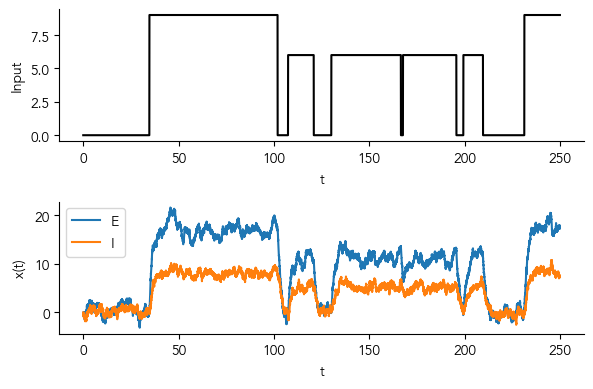

In [25]:
plt.figure(figsize=(6,4))

plt.subplot(2,1,1)
plt.plot(np.arange(steps)*dt, hs[inputs], c='k')
plt.xlabel('t')
plt.ylabel('Input')

plt.subplot(2,1,2)
for idx, state in enumerate(states.T):
    plt.plot(np.arange(steps)*dt, state, c=colors(idx), label=labels[idx])
plt.xlabel('t')
plt.ylabel('x(t)')
plt.legend()

sns.despine()
plt.tight_layout()
plt.show()

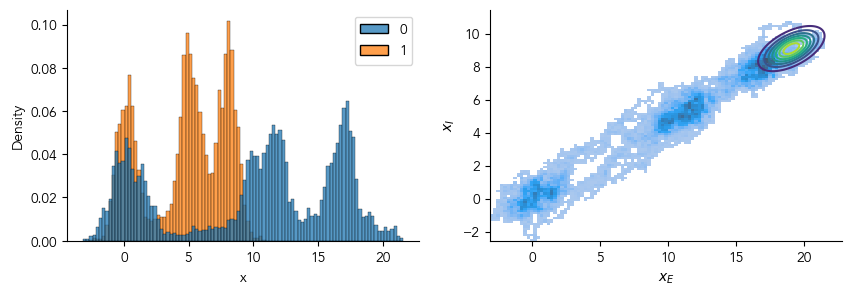

In [26]:
### Plot statistics at stationarity
t_min = int(1e3)

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
sns.histplot(states[t_min:], bins=100, stat='density')
#plt.axvline(xplus, ls='--', c='k')
#plt.axvline(xminus, ls='--', c='k')
sns.despine()
plt.xlabel('x')

plt.subplot(1,2,2)
ax = sns.histplot(x=states[t_min:,0], y=states[t_min:,1], bins=100)

#x, y = np.mgrid[states[t_min:,0].min():states[t_min:,0].max():.01, states[t_min:,1].min():states[t_min:,1].max():.01]
#pos = np.dstack((x, y))
#ax.contour(x,y, multivariate_normal(mean=mus, cov=sigma).pdf(pos))

plt.xlabel(r'$x_E$')
plt.ylabel(r'$x_I$')
sns.despine()

plt.show()